In [1]:
import pandas as pd
import os
import numpy as np
from IPython.core.display_functions import clear_output
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from datetime import datetime
import time
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt

In [21]:
DATA_PATH = '../../Pokemon-data/'
NORMALIZED_DATA = '../../Training-baseline/'
SEED = 42
BATCH_SIZE = 64
EPOCHS = 20
PRETRAINED = True
MODEL_NAME = str(EPOCHS) + "Epochs-freeze"
checkpoint_path = './saved-models/'
TRAINING_METRICS = './training-metrics/'
n_epochs_stop = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
metadata = pd.read_csv('metadata/pokemon.csv')

pokemon_names = [x for x in os.listdir(NORMALIZED_DATA)]

filtered_metadata = metadata[metadata.name.isin(pokemon_names)]

filtered_list = filtered_metadata.loc[:,'name'].tolist()

filtered_metadata = filtered_metadata.loc[:,['name', 'type1']]

#fire_data = filtered_metadata[filtered_metadata["type1"] == 'fire']
#grass_data = filtered_metadata[filtered_metadata["type1"] == 'grass']
#filtered_metadata = pd.concat([fire_data, grass_data], ignore_index=True)

filtered_metadata.type1 = pd.Categorical(filtered_metadata.type1)
filtered_metadata['code'] = filtered_metadata.type1.cat.codes
print(filtered_metadata['code'])

def compile_training_data_to_list():
    all_data = []
    for pokemon in os.listdir(NORMALIZED_DATA):
        all_data += [pokemon + '/' + x for x in os.listdir(NORMALIZED_DATA + pokemon)]

    results = create_annotated_dataframe(all_data)
    return results

def create_annotated_dataframe(all_data):
    base_data = {'file_name': [], 'name': [], 'label': []}
    for item in all_data:
        if len(filtered_metadata[filtered_metadata['name'].str.contains(item.split('/')[0])]):
            base_data['file_name'].append(item)
            base_data['name'].append(item.split('/')[0])
            # yes, this is a bit ugly, but we have to match with the metadata
            base_data['label'].append(
                filtered_metadata[
                    filtered_metadata['name']==(item.split('/')[0])
                ].loc[:,'code'].tolist()[0])

    results, y_train = create_encoded_dataframe(base_data)
    return results, y_train

def create_encoded_dataframe(base_data):
    results = pd.DataFrame(base_data, columns = ['file_name', 'name', 'label'])
    labels = np.unique(results["label"])
    max_value = np.max(labels) + 1
    Y_train = np.eye(max_value)[results["label"]]
    return results, Y_train

0       9
1       9
2       9
3       6
4       6
       ..
714     7
715     4
716     1
718    15
720     6
Name: code, Length: 703, dtype: int8


In [4]:
encoded_data, y_train = compile_training_data_to_list()

In [5]:
class CustomDataset(Dataset):
	def __init__(self, x, y, img_dir):
		self.x = x
		self.y = y
		self.img_dir = img_dir
		self.classes = np.unique(self.y)


	def __len__(self):
		return len(self.x)


	def __getitem__(self, idx):
		img_path = os.path.join(self.img_dir, self.x[idx])
        # use the slice to remove a possible 4th alpha channel
		#image = iio.v2.imread(img_path)[:,:,:3]
		image = np.load(img_path)[:,:,:3]
		image = image.astype(np.float32)
		label = self.y[idx]
		return image, label

In [6]:
def stratified_split(dataset, labels):
    x_train, x_val, y_train, y_val = train_test_split(dataset['file_name'].to_numpy(),
                                                  labels,
                                                  test_size=0.25,
                                                  stratify=dataset['label'],
                                                  random_state=SEED)

    trainSet = CustomDataset(x_train, y_train, NORMALIZED_DATA)
    valSet = CustomDataset(x_val, y_val, NORMALIZED_DATA)
    return trainSet, valSet

In [7]:
def print_performance_metrics(currentEpoch, avgTrainLoss, trainCorrect, avgValLoss, valCorrect, trainf1, valf1):
    print()
    print(f"[INFO] EPOCH: {currentEpoch + 1}/{EPOCHS}")
    print(f"Train loss: {avgTrainLoss :.6f}, Train accuracy: {trainCorrect :.4f}")
    print(f"Val loss: 	{avgValLoss :.6f}, Val accuracy:   {valCorrect :.4f}")
    print(f"Train F1: 	{trainf1 :.6f}")
    print(f"Val F1: 	{valf1 :.6f}")
    print(f"---------------------------------------------------- \n")

In [8]:
train, val = stratified_split(encoded_data, y_train)
trainDataLoader = DataLoader(train, batch_size=BATCH_SIZE)
valDataLoader = DataLoader(val, batch_size=BATCH_SIZE)

trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

In [9]:
from torchvision import models
model = models.efficientnet_b0(pretrained=True)

In [10]:
for param in model.parameters():
    param.requires_grad = False

In [11]:
import torch.nn as nn
# Add on classifier
model.classifier = nn.Sequential(
                      nn.Linear(1280, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.5),
                      nn.Linear(256, 18),                   
                      nn.LogSoftmax(dim=1))

In [12]:
model = model.to('cuda')

In [13]:
torch.manual_seed(SEED)
class_acc = []
epochs_no_improve = 0
metrics = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": [],
	"trainf1": [],
    "valf1": []
}

In [14]:
from torch import optim
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [15]:
# measure how long training is going to take
print("[INFO] training the network...")
startTime = time.time()

for epoch in range(EPOCHS):
    print(f"[INFO] starting training for epoch: {epoch + 1} at {datetime.now().strftime('%H:%M:%S')}")

    train_preds = []
    train_target = []

    val_preds = []
    val_target = []

    model.train()

    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0
    # initialize the number of correct predictions in the training
    # and validation step
    trainCorrect = 0
    valCorrect = 0
    min_val_loss = 100

    for data, targets in tqdm(trainDataLoader, desc="Training progress"):
        data = data.transpose(1, 3)
        data = data.transpose(2, 3)

        optimizer.zero_grad()

        data = data.float()
        data, targets = (data.to(device), targets.to(device))
        # Generate predictions
        out = model(data)
        # Calculate loss
        loss = criterion(out, targets)
        # Backpropagation
        loss.backward()
        # Update model parameters
        optimizer.step()
        # add the loss to the total training loss so far and
        # calculate the number of correct predictions
        totalTrainLoss += loss

        for item in out:
            train_preds.append(np.argmax(item.cpu().detach().numpy()))
            trainCorrect += (item.argmax(0) == targets.argmax(0)).type(torch.float).sum().item()

        for label in targets:
            train_target.append(label.cpu().detach().numpy().argmax(0))

    with torch.no_grad():
        model.eval()
        print(f"[INFO] starting evaluation for epoch: {epoch + 1} at {datetime.now().strftime('%H:%M:%S')}")
        for data, targets in tqdm(valDataLoader, desc="Validation progress"):
            data = data.transpose(1, 3)
            data = data.transpose(2, 3)

            data = data.float()
            data, targets = (data.to(device), targets.to(device))
            # Generate predictions
            out = model(data)
            # Calculate loss
            totalValLoss += criterion(out, targets)
            for item in out:
                val_preds.append(np.argmax(item.cpu().detach().numpy()))
                valCorrect += (item.argmax(0) == targets.argmax(0)).type(torch.float).sum().item()

            for label in targets:
                val_target.append(label.cpu().detach().numpy().argmax(0))

        # Average validation loss
        avg_val_loss = totalValLoss / valSteps
        # If the validation loss is at a minimum
        if avg_val_loss < min_val_loss:
            # Save the model
            torch.save(model, checkpoint_path + MODEL_NAME + ".pt")
            epochs_no_improve = 0
            min_val_loss = avg_val_loss

        else:
            epochs_no_improve += 1
            # Check early stopping condition
            if epochs_no_improve == n_epochs_stop:
                print('Early stopping!')

    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps

    # calculate per class accuracy via confusion matrix
    matrix = confusion_matrix(val_target, val_preds)
    class_acc.append(matrix.diagonal() / matrix.sum(axis=1))

    # calculate the training and validation accuracy
    trainCorrect = trainCorrect / len(trainDataLoader.dataset)
    valCorrect = valCorrect / len(valDataLoader.dataset)

    # calculate macro F1 score
    trainf1 = f1_score(train_target, train_preds, average='macro')
    valf1 = f1_score(val_target, val_preds, average="macro")

    # update our training history
    metrics["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    metrics["train_acc"].append(trainCorrect)
    metrics["val_loss"].append(avg_val_loss.cpu().detach().numpy())
    metrics["val_acc"].append(valCorrect)
    metrics['trainf1'].append(trainf1)
    metrics['valf1'].append(valf1)

    # print the model training and validation information
    clear_output()
    print_performance_metrics(epoch, avgTrainLoss, trainCorrect, avg_val_loss, valCorrect, trainf1, valf1)

endTime = time.time()
print(f"[INFO] total time taken to train the model: {(endTime - startTime) / 60 :.2f}min")

[INFO] training the network...
[INFO] starting training for epoch: 1 at 21:17:54


Training progress: 100%|██████████| 142/142 [04:11<00:00,  1.77s/it]


[INFO] starting evaluation for epoch: 1 at 21:22:05


Validation progress: 100%|██████████| 48/48 [00:46<00:00,  1.03it/s]



[INFO] EPOCH: 1/20
Train loss: 2.324524, Train accuracy: 0.5980
Val loss: 	1.959274, Val accuracy:   0.6086
Train F1: 	0.157386
Val F1: 	0.267922
---------------------------------------------------- 

[INFO] starting training for epoch: 2 at 21:22:51


Training progress: 100%|██████████| 142/142 [03:56<00:00,  1.66s/it]


[INFO] starting evaluation for epoch: 2 at 21:26:48


Validation progress: 100%|██████████| 48/48 [00:36<00:00,  1.33it/s]



[INFO] EPOCH: 2/20
Train loss: 1.862351, Train accuracy: 0.7002
Val loss: 	1.748879, Val accuracy:   0.6464
Train F1: 	0.313153
Val F1: 	0.370077
---------------------------------------------------- 

[INFO] starting training for epoch: 3 at 21:27:24


Training progress: 100%|██████████| 142/142 [03:55<00:00,  1.66s/it]


[INFO] starting evaluation for epoch: 3 at 21:31:19


Validation progress: 100%|██████████| 48/48 [00:35<00:00,  1.34it/s]



[INFO] EPOCH: 3/20
Train loss: 1.637691, Train accuracy: 0.7228
Val loss: 	1.655688, Val accuracy:   0.6540
Train F1: 	0.407893
Val F1: 	0.412474
---------------------------------------------------- 

[INFO] starting training for epoch: 4 at 21:31:55


Training progress: 100%|██████████| 142/142 [04:01<00:00,  1.70s/it]


[INFO] starting evaluation for epoch: 4 at 21:35:56


Validation progress: 100%|██████████| 48/48 [00:35<00:00,  1.36it/s]



[INFO] EPOCH: 4/20
Train loss: 1.496362, Train accuracy: 0.7118
Val loss: 	1.605677, Val accuracy:   0.6570
Train F1: 	0.464993
Val F1: 	0.433357
---------------------------------------------------- 

[INFO] starting training for epoch: 5 at 21:36:32


Training progress: 100%|██████████| 142/142 [03:57<00:00,  1.67s/it]


[INFO] starting evaluation for epoch: 5 at 21:40:29


Validation progress: 100%|██████████| 48/48 [00:34<00:00,  1.37it/s]



[INFO] EPOCH: 5/20
Train loss: 1.374349, Train accuracy: 0.7305
Val loss: 	1.563392, Val accuracy:   0.6848
Train F1: 	0.505067
Val F1: 	0.447022
---------------------------------------------------- 

[INFO] starting training for epoch: 6 at 21:41:04


Training progress: 100%|██████████| 142/142 [03:52<00:00,  1.64s/it]


[INFO] starting evaluation for epoch: 6 at 21:44:57


Validation progress: 100%|██████████| 48/48 [00:36<00:00,  1.32it/s]



[INFO] EPOCH: 6/20
Train loss: 1.265592, Train accuracy: 0.7201
Val loss: 	1.544270, Val accuracy:   0.6785
Train F1: 	0.542096
Val F1: 	0.457335
---------------------------------------------------- 

[INFO] starting training for epoch: 7 at 21:45:33


Training progress: 100%|██████████| 142/142 [03:52<00:00,  1.64s/it]


[INFO] starting evaluation for epoch: 7 at 21:49:26


Validation progress: 100%|██████████| 48/48 [00:36<00:00,  1.32it/s]



[INFO] EPOCH: 7/20
Train loss: 1.176982, Train accuracy: 0.7219
Val loss: 	1.525777, Val accuracy:   0.6874
Train F1: 	0.570508
Val F1: 	0.464752
---------------------------------------------------- 

[INFO] starting training for epoch: 8 at 21:50:03


Training progress: 100%|██████████| 142/142 [04:29<00:00,  1.90s/it]


[INFO] starting evaluation for epoch: 8 at 21:54:32


Validation progress: 100%|██████████| 48/48 [00:45<00:00,  1.07it/s]



[INFO] EPOCH: 8/20
Train loss: 1.112559, Train accuracy: 0.7289
Val loss: 	1.530666, Val accuracy:   0.6599
Train F1: 	0.599042
Val F1: 	0.456358
---------------------------------------------------- 

[INFO] starting training for epoch: 9 at 21:55:18


Training progress: 100%|██████████| 142/142 [04:18<00:00,  1.82s/it]


[INFO] starting evaluation for epoch: 9 at 21:59:36


Validation progress: 100%|██████████| 48/48 [00:37<00:00,  1.27it/s]



[INFO] EPOCH: 9/20
Train loss: 1.036940, Train accuracy: 0.7249
Val loss: 	1.522409, Val accuracy:   0.7493
Train F1: 	0.628609
Val F1: 	0.467093
---------------------------------------------------- 

[INFO] starting training for epoch: 10 at 22:00:14


Training progress: 100%|██████████| 142/142 [04:14<00:00,  1.79s/it]


[INFO] starting evaluation for epoch: 10 at 22:04:29


Validation progress: 100%|██████████| 48/48 [00:36<00:00,  1.30it/s]



[INFO] EPOCH: 10/20
Train loss: 0.971796, Train accuracy: 0.7220
Val loss: 	1.526019, Val accuracy:   0.7252
Train F1: 	0.652473
Val F1: 	0.462174
---------------------------------------------------- 

[INFO] starting training for epoch: 11 at 22:05:06


Training progress: 100%|██████████| 142/142 [03:59<00:00,  1.68s/it]


[INFO] starting evaluation for epoch: 11 at 22:09:05


Validation progress: 100%|██████████| 48/48 [00:36<00:00,  1.31it/s]



[INFO] EPOCH: 11/20
Train loss: 0.919164, Train accuracy: 0.7263
Val loss: 	1.532829, Val accuracy:   0.7136
Train F1: 	0.671594
Val F1: 	0.461218
---------------------------------------------------- 

[INFO] starting training for epoch: 12 at 22:09:42


Training progress: 100%|██████████| 142/142 [04:00<00:00,  1.70s/it]


[INFO] starting evaluation for epoch: 12 at 22:13:42


Validation progress: 100%|██████████| 48/48 [00:38<00:00,  1.25it/s]



[INFO] EPOCH: 12/20
Train loss: 0.863173, Train accuracy: 0.7158
Val loss: 	1.529487, Val accuracy:   0.7023
Train F1: 	0.699650
Val F1: 	0.473629
---------------------------------------------------- 

[INFO] starting training for epoch: 13 at 22:14:21


Training progress: 100%|██████████| 142/142 [04:05<00:00,  1.73s/it]


[INFO] starting evaluation for epoch: 13 at 22:18:26


Validation progress: 100%|██████████| 48/48 [00:37<00:00,  1.29it/s]



[INFO] EPOCH: 13/20
Train loss: 0.828529, Train accuracy: 0.7258
Val loss: 	1.554563, Val accuracy:   0.7060
Train F1: 	0.714926
Val F1: 	0.469102
---------------------------------------------------- 

[INFO] starting training for epoch: 14 at 22:19:03


Training progress: 100%|██████████| 142/142 [04:09<00:00,  1.76s/it]


[INFO] starting evaluation for epoch: 14 at 22:23:13


Validation progress: 100%|██████████| 48/48 [00:38<00:00,  1.24it/s]



[INFO] EPOCH: 14/20
Train loss: 0.771479, Train accuracy: 0.7123
Val loss: 	1.567172, Val accuracy:   0.6983
Train F1: 	0.735512
Val F1: 	0.460666
---------------------------------------------------- 

[INFO] starting training for epoch: 15 at 22:23:52


Training progress: 100%|██████████| 142/142 [04:04<00:00,  1.72s/it]


[INFO] starting evaluation for epoch: 15 at 22:27:56


Validation progress: 100%|██████████| 48/48 [00:37<00:00,  1.27it/s]



[INFO] EPOCH: 15/20
Train loss: 0.735170, Train accuracy: 0.7269
Val loss: 	1.575008, Val accuracy:   0.7007
Train F1: 	0.757617
Val F1: 	0.473351
---------------------------------------------------- 

[INFO] starting training for epoch: 16 at 22:28:34


Training progress: 100%|██████████| 142/142 [04:03<00:00,  1.71s/it]


[INFO] starting evaluation for epoch: 16 at 22:32:38


Validation progress: 100%|██████████| 48/48 [00:37<00:00,  1.28it/s]



[INFO] EPOCH: 16/20
Train loss: 0.705785, Train accuracy: 0.7231
Val loss: 	1.569285, Val accuracy:   0.7142
Train F1: 	0.766572
Val F1: 	0.469917
---------------------------------------------------- 

[INFO] starting training for epoch: 17 at 22:33:15


Training progress: 100%|██████████| 142/142 [04:11<00:00,  1.77s/it]


[INFO] starting evaluation for epoch: 17 at 22:37:27


Validation progress: 100%|██████████| 48/48 [00:39<00:00,  1.22it/s]



[INFO] EPOCH: 17/20
Train loss: 0.682773, Train accuracy: 0.7256
Val loss: 	1.594237, Val accuracy:   0.7487
Train F1: 	0.773358
Val F1: 	0.470267
---------------------------------------------------- 

[INFO] starting training for epoch: 18 at 22:38:06


Training progress: 100%|██████████| 142/142 [04:06<00:00,  1.74s/it]


[INFO] starting evaluation for epoch: 18 at 22:42:13


Validation progress: 100%|██████████| 48/48 [00:37<00:00,  1.27it/s]



[INFO] EPOCH: 18/20
Train loss: 0.657309, Train accuracy: 0.7214
Val loss: 	1.596874, Val accuracy:   0.7401
Train F1: 	0.780274
Val F1: 	0.475642
---------------------------------------------------- 

[INFO] starting training for epoch: 19 at 22:42:51


Training progress: 100%|██████████| 142/142 [04:06<00:00,  1.74s/it]


[INFO] starting evaluation for epoch: 19 at 22:46:57


Validation progress: 100%|██████████| 48/48 [00:48<00:00,  1.01s/it]



[INFO] EPOCH: 19/20
Train loss: 0.612802, Train accuracy: 0.7181
Val loss: 	1.604424, Val accuracy:   0.7235
Train F1: 	0.798217
Val F1: 	0.476723
---------------------------------------------------- 

[INFO] starting training for epoch: 20 at 22:47:46


Training progress: 100%|██████████| 142/142 [05:07<00:00,  2.17s/it]


[INFO] starting evaluation for epoch: 20 at 22:52:54


Validation progress: 100%|██████████| 48/48 [00:46<00:00,  1.04it/s]



[INFO] EPOCH: 20/20
Train loss: 0.608981, Train accuracy: 0.7237
Val loss: 	1.603979, Val accuracy:   0.7331
Train F1: 	0.799315
Val F1: 	0.476740
---------------------------------------------------- 

[INFO] total time taken to train the model: 95.79min


In [24]:
metrics = pd.DataFrame.from_dict(metrics)
metrics.to_csv(TRAINING_METRICS + MODEL_NAME + ".csv")

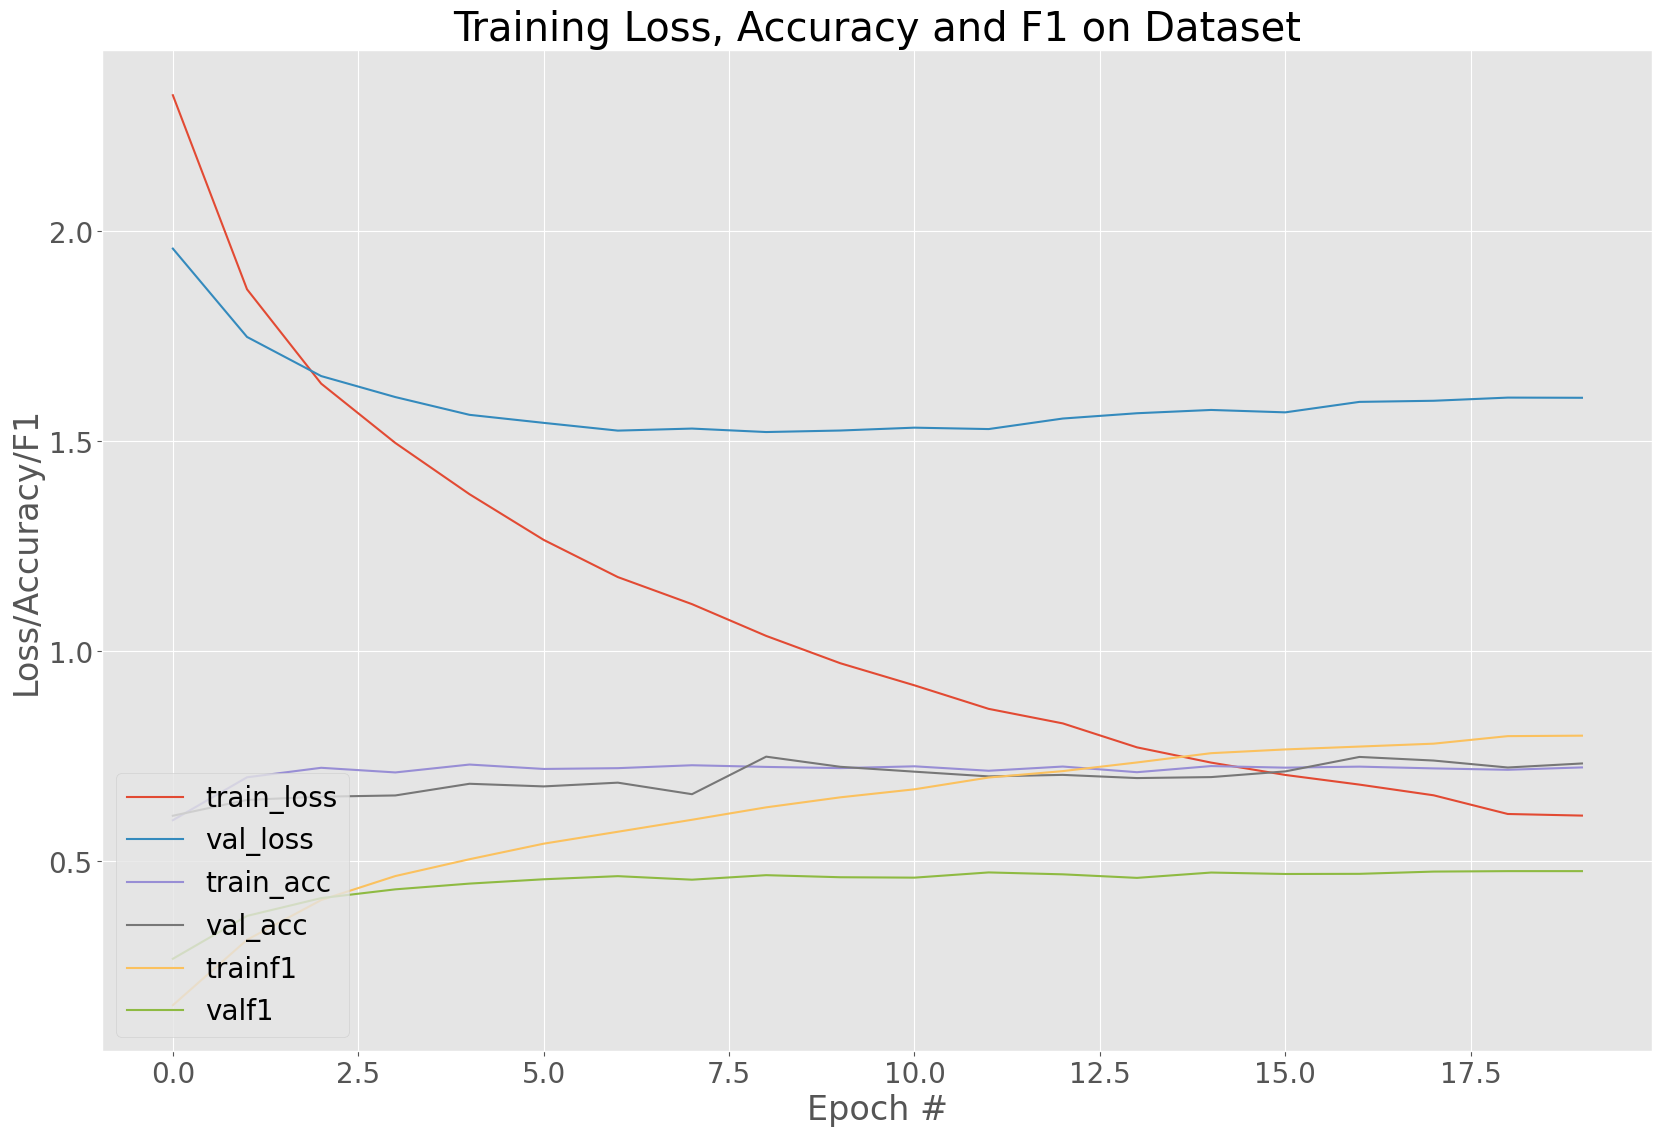

In [19]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.rcParams['font.size'] = 20
plt.figure(figsize=(20, 13))
plt.plot(metrics["train_loss"], label="train_loss")
plt.plot(metrics["val_loss"], label="val_loss")
plt.plot(metrics["train_acc"], label="train_acc")
plt.plot(metrics["val_acc"], label="val_acc")
plt.plot(metrics["trainf1"], label="trainf1")
plt.plot(metrics["valf1"], label="valf1")
plt.title("Training Loss, Accuracy and F1 on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy/F1")
plt.legend(loc="lower left")